# Photometry FLMM Guide Part IV: Testing effects of factor variables -- akin to ANOVA
## Authors: Gabriel Loewinger, Erjia Cui
### 2024-09-07
### rpy2 implementation: Josh Lawrimore

Please install the R packages lmerTests and emmeans in R prior to running this notebook.

```R
install.packages('lmerTest')
install.packages('emmeans')
```


# Part IV: Factor variables

Neuroscience is full of between-group and/or within-subject between-condition designs. Analysts often compare mean differences in photometry values between these groups/conditions with variants of ANOVA methods (e.g., 1-way, 2-way, repeated measures, etc.). Testing these differences in an FLMM setting is straightforward and is really no different than testing multiple binary effects. This is expected since standard ANOVAs can be expressed as a linear regression with the factor variables expanded into a collection of binary indicator variables. 

Using FLMM to analyze factor variables provides a significance test of whether there are differences in the average signal between the factor levels at each trial timepoint. One can use functional random effects to model heterogeneity in these differences across, for example, animals, conditions, sessions, etc. One can also adjust for other variables or test multiple effects.   

## Data Formating

Let's load some data from the same Pavlovian task used in Parts I - III, but with more sessions and select the subset of rows corresponding to the CS+. Again for demonstration purpose, we use data taken from Test 4 of [Jeong et al., 2022](https://www.science.org/doi/full/10.1126/science.abq6740) and we thank the authors for generously making their data public and helping us analyze it.

To get the idea of ANOVA testing, let's treat ${session}$ number as a factor variable and each ${session}$ number is treated as a different level. This was the strategy we applied to test whether dopamine "backpropogates" in Appendix Figure 17 of our paper, [Loewinger et al., 2024](https://elifesciences.org/reviewed-preprints/95802).

Although we use a temporal variable as a factor in this case, the code and reasoning applies directly to cases where the factor variable encodes, for example, treatment groups, cue-type, experimental condition, etc. One might wonder whether there are differences between testing for ${session}$, a within-subject factor (for which we might typically apply a repeated measures ANOVA), and a between-subject factor (e.g., treatment group). From the point of view of the FLMM, the code is the same, but what differs is what random effects we might include (e.g., it does not make sense to include a subject-specific random effect of treatment group in a between-subjects design because animals are never in more than one group).

In [1]:
def r2py(mod):
    d = dict(zip(mod.names(), list(mod)))
    return d

def fui2(**kwargs):
    m = fui(**kwargs)
    return r2py(m)

In [2]:
import pandas as pd
from rpy2.robjects import pandas2ri, r

from fast_fmm_rpy2.fmm_run import fui
from fast_fmm_rpy2.ingest import (
    pass_pandas_to_r,
    read_csv_for_r
)
from fast_fmm_rpy2.plot_fui import plot_fui

df: pd.DataFrame = read_csv_for_r(r"./anova_data.csv")
no_cs= df.loc[df["cs"] == 0]
no_cs
pass_pandas_to_r(no_cs, r_var_name="dat")
r('dat[,"session"] = factor(dat[,"session"])')
r('dat[,"session"] = relevel(dat[,"session"], ref = "1")')


R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1:   
R callback write-console: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :  
R callback write-console: 
   
R callback write-console:  library ‘/usr/lib/R/site-library’ contains no packages
  
R callback write-console: 2:   
R callback write-console: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :  
R callback write-console: 
   
R callback write-console:  library ‘/usr/lib/R/site-library’ contains no packages
  
R callback write-console: 3:   
R callback write-console: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :  
R callback write-console: 
   
R callback write-console:  library ‘/usr/lib/R/site-library’ contains no packages
  
R callback write-console: 4:   
R callback write-console: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :  

In [4]:
mod1 = fui2(csv_filepath=None, formula="photometry ~ session + (1 | id)", parallel=False, r_var_name="dat")
mod2 = fui2(csv_filepath=None, formula="photometry ~ session + (session | id)", parallel=False, r_var_name="dat")


[1] "Step 1: Fit Massively Univariate Mixed Models"
[1] "Step 2: Smoothing"
[1] "Step 3: Inference (Analytic)"
[1] "Step 3.1: Preparation"
[1] "Step 3.1.1: Method of Moments Covariance Estimator Random Intercept"
[1] "Step 3.1.2: Smooth G"
[1] "Step 3.2: First step"
[1] "Step 3.2.1: First step"
[1] "Step 3.3: Second step"


R callback write-console: Complete!
 - Use plot_fui() function to plot estimates.
 - For more information, run the command:  ?plot_fui
  


[1] "Step 1: Fit Massively Univariate Mixed Models"
[1] "Step 2: Smoothing"
[1] "Step 3: Inference (Analytic)"
[1] "Step 3.1: Preparation"
[1] "Step 3.1.1: Preparation B"
[1] "Step 3.1.1: Method of Moments Covariance Estimator"
[1] "Step 3.1.2: Smooth G"
[1] "Step 3.2: First step"
[1] "Step 3.2.1: First step"
[1] "Step 3.3: Second step"


R callback write-console: Complete!
 - Use plot_fui() function to plot estimates.
 - For more information, run the command:  ?plot_fui
  


In [5]:
mod1['aic'].mean()


AIC     3338.504917
BIC     3380.504322
cAIC            NaN
dtype: float64

In [6]:
mod2['aic'].mean()


AIC     3347.774076
BIC     3494.771991
cAIC            NaN
dtype: float64

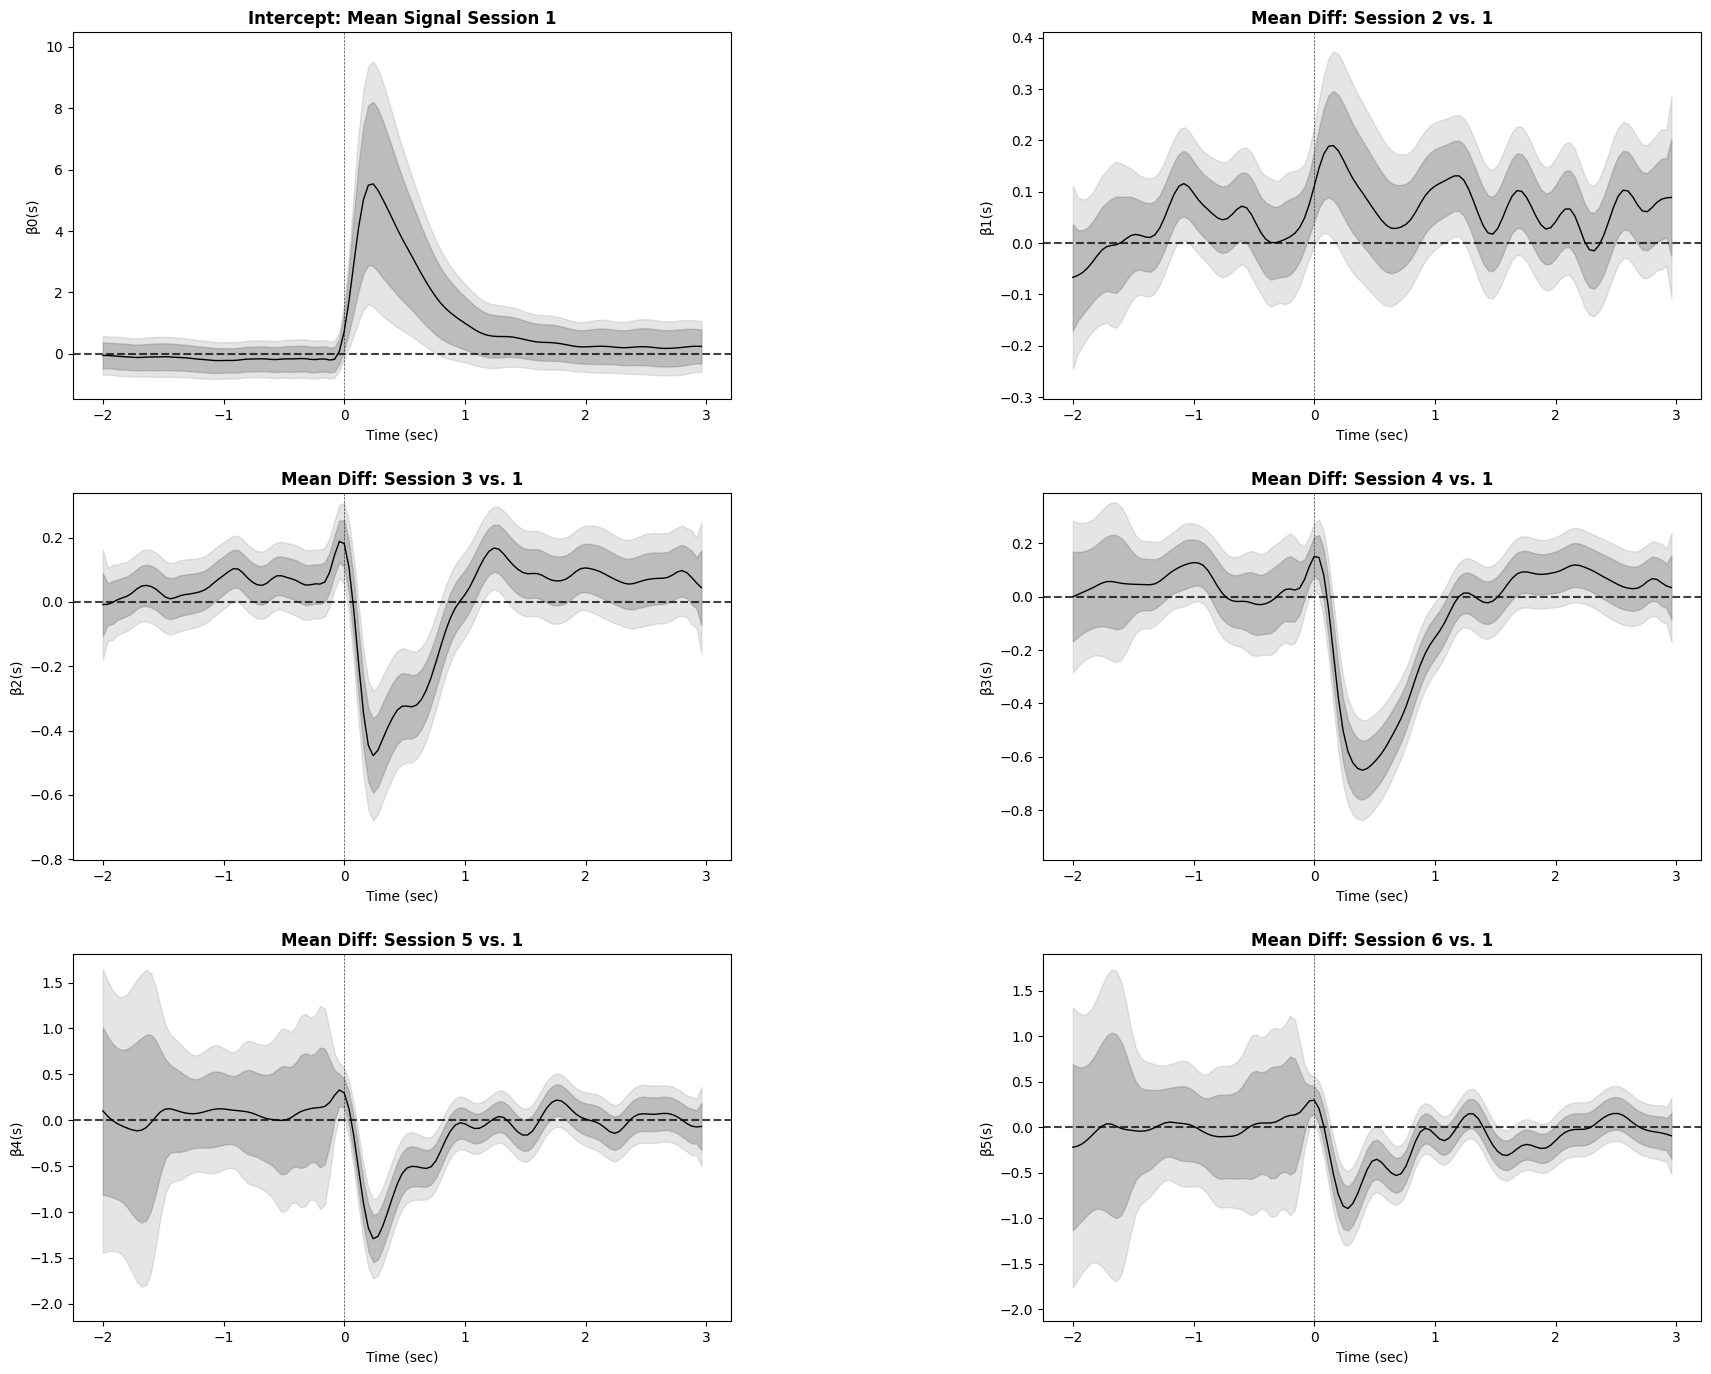

In [7]:
# plot model with best model fit (AIC/BIC)
figure = plot_fui(mod1, 
         xlab = "Time (sec)", # label x-axis
         x_rescale = 25, # rescale x-axis to be in sec - photometry sampled at 25 Hz 
         align_x = 2, # align to time of cue onset
         title_names = ["Intercept: Mean Signal Session 1", "Mean Diff: Session 2 vs. 1",
                         "Mean Diff: Session 3 vs. 1", "Mean Diff: Session 4 vs. 1",
                         "Mean Diff: Session 5 vs. 1", "Mean Diff: Session 6 vs. 1"]
         )
figure.set_size_inches(20, 14)


The interpretation for the functional intercept at trial timepoint $s$ is "the mean signal on Session 1 at timepoint $s$." The remaining functional fixed effect coefficients show the mean change in the signal between the correspoinding session and baseline session (session 1 here). For example, the estimate $\widehat{\beta}_2(s)$ has the interpretation as "the mean difference in signal values between sessions 3 and session 1 at trial timepoint $s$." We see that the average signal magnitude is significantly lower on session 3 than on session 1 in roughly the first second after cue onset.

## "ANOVA - Style" Testing

ANOVA tables are helpful in some applications because they provide an omnibus test for an effect of the (factor) variable before applying pairwise tests (often in the form of posthocs). The construction of such a table is more complicated in FLMM models, especially alongside $joint$ confidence intervals. One solution, albeit an imperfect one, is to fit a standard LMM on a summary measure, constructed from time intervals that exhibited effects in the FLMM, and then generate an ANOVA table on the LMM. Then one can present this alongside results from the FLMM. So for example, in the present example, the differences across the different sessions are significant during the one second period after cue onset. We construct an average AUC during that time interval, fit a LMM with the same model specification and examine the ANOVA table.


In [8]:
# Run all calculations for lmerTest in r using rpy2
# please install lmerTest in R before running this by calling install.packages("lmerTest") in R
r('library("lmerTest")')
r('library(dplyr)')
r(r'dat = read.csv("anova_data.csv") %>% dplyr::filter(cs == 0)')
r('dat[,"session"] = factor(dat[,"session"])')
r('dat[,"session"] = relevel(dat[,"session"], ref = "1")')
r('photo_names = paste0("photometry.", 51:75)')
r('photo_AUC = rowMeans(dat[,photo_names])')
r('lmm = lmerTest::lmer(photo_AUC ~ session + (1 | id), data = dat)')
x = r('anova(lmm, ddf = "Satterthwaite")')
pandas2ri.rpy2py(x)


R callback write-console: Loading required package: lme4
  
R callback write-console: Loading required package: Matrix
  
R callback write-console: 
Attaching package: ‘lmerTest’

  
R callback write-console: The following object is masked from ‘package:lme4’:

    lmer

  
R callback write-console: The following object is masked from ‘package:stats’:

    step

  
R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: In optwrap(optimizer, devfun, getStart(start, rho$pp), lower = rho$lower,  :  
R callback write-console: 
   
R callback write-console:  convergence code 1 from bobyqa: bobyqa -- maximum number of function evaluations exceeded
  
R callback write-console: 
Attaching package: ‘dplyr’

  
R callback write-console: The following objects are masked from ‘package:stats’:

    filter, lag

  
R callback write-console: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

  


,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
session,50.862916,10.172583,5,1396.129427,16.106899,1.829882e-15


This secondary analysis shows that indeed, that ${session}$ is statistically significant and provides additional assurance that examining the pairwise differences outputted by the FLMM was not premature. 

The summary measure (AUC) was constructed based upon the results of an inferential test because the secondary LMM was fit on an AUC that was constructed based upon prior analysis results (from the FLMM). This constitutes a post-selection inference problem and a more comprehensive solution would be the subject of future statistical methods research, a topic outside the scope of the present vignette. Analysts should report the sequence of steps they applied to ensure it is clear that a summary measure was constructed based on results from an FLMM.

## Switching baselines for additional pairwise comparisons

Sometimes we need to estimate pairwise comparisons (akin to posthocs) beyond those provided in the initial analysis. This can easily be completed by changing the baseline factor level specified above and rerunning the model. For example, let's say we wanted to compare Session 2 and Session 3, just adjust the `ref` arguent in the `relevel()` function and fit the same model.


[1] "Step 1: Fit Massively Univariate Mixed Models"
[1] "Step 2: Smoothing"
[1] "Step 3: Inference (Analytic)"
[1] "Step 3.1: Preparation"
[1] "Step 3.1.1: Method of Moments Covariance Estimator Random Intercept"
[1] "Step 3.1.2: Smooth G"
[1] "Step 3.2: First step"
[1] "Step 3.2.1: First step"
[1] "Step 3.3: Second step"


R callback write-console: Complete!
 - Use plot_fui() function to plot estimates.
 - For more information, run the command:  ?plot_fui
  


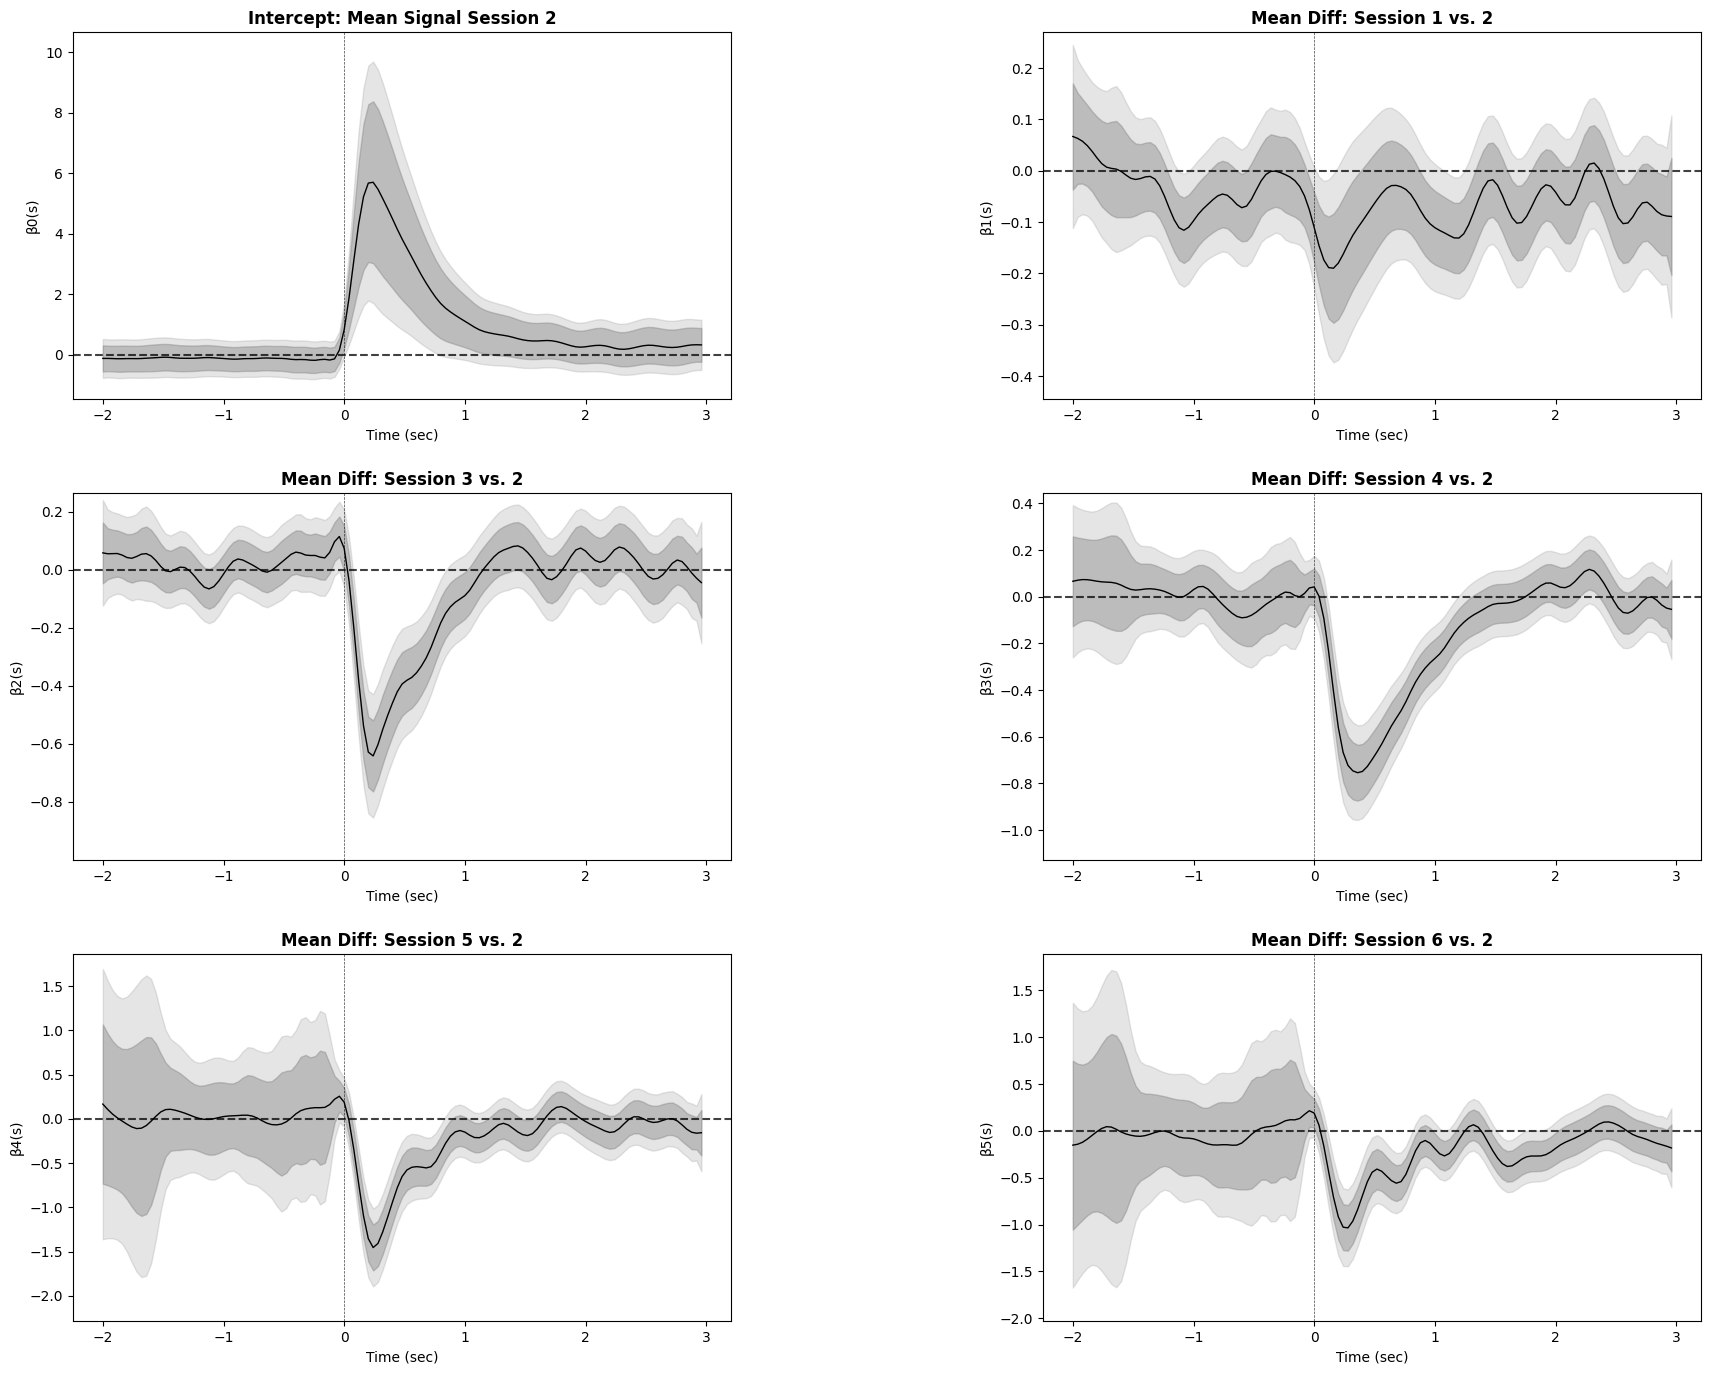

In [11]:
r('dat[,"session"] = relevel(dat[,"session"], ref = "2")') # set second session to reference level
mod1 = fui2(csv_filepath=None, formula='photometry ~ session + (1 | id)', parallel=False, r_var_name='dat') # fit same model as before
figure = plot_fui(mod1, 
         xlab = "Time (sec)", # label x-axis
         x_rescale = 25, # rescale x-axis to be in sec - photometry sampled at 25 Hz 
         align_x = 2, # align to time of cue onset
         title_names = ["Intercept: Mean Signal Session 2", "Mean Diff: Session 1 vs. 2",
                         "Mean Diff: Session 3 vs. 2", "Mean Diff: Session 4 vs. 2",
                         "Mean Diff: Session 5 vs. 2", "Mean Diff: Session 6 vs. 2"]
         )
figure.set_size_inches(20, 14)


This brings up a similar posthoc question as before. If you want to make multiple pairwise comparisons, some effort to account for the multiple comparisons may be necessary, especially if many comparisons are made. While there is no straightforward way to use joint confidence intervals for multiple comparisons adjustment, one can report adjustments for posthocs in an LMM framework alongside their FLMM output to further bolster their results.

In [12]:
# please install emmeans in R before running this by calling install.packages("emmeans") in R
r('lmm = lmerTest::lmer(photo_AUC ~ session + (1 | id), data = dat)') # random intercept 
emmeans = r('emmeans::emmeans(lmm, list(pairwise ~ session), adjust = "tukey", lmer.df = "satterthwaite")')
print(emmeans)


$`emmeans of session`
 session emmean    SE   df lower.CL upper.CL
 2         3.22 0.827 6.03    1.200     5.24
 1         3.12 0.827 6.02    1.103     5.15
 3         2.89 0.827 6.02    0.873     4.92
 4         2.75 0.827 6.03    0.724     4.77
 5         2.59 0.835 6.27    0.563     4.61
 6         2.75 0.835 6.27    0.725     4.77

Degrees-of-freedom method: satterthwaite 
Confidence level used: 0.95 

$`pairwise differences of session`
 1                   estimate     SE   df t.ratio p.value
 session2 - session1  0.09706 0.0618 1396   1.570  0.6187
 session2 - session3  0.32757 0.0617 1396   5.307  <.0001
 session2 - session4  0.47640 0.0651 1396   7.321  <.0001
 session2 - session5  0.63645 0.1320 1396   4.833  <.0001
 session2 - session6  0.47395 0.1320 1396   3.599  0.0045
 session1 - session3  0.23050 0.0605 1396   3.809  0.0020
 session1 - session4  0.37934 0.0638 1396   5.948  <.0001
 session1 - session5  0.53939 0.1310 1396   4.103  0.0006
 session1 - session6  0.37689 0.1

# Pointwise or Joint 95% Confidence Intervals
We recommend basing inference off of joint CIs for two reasons: interpretability and multiple comparisons corrections. Joint CIs identify $intervals$ of the trial during which the effects are significant, while pointwise identify individual timepoints that are significant. Typically analyst are more interested in time intervals and so we argue joint CIs are more interpretable in photometry analyses. Joint CIs also provide an adjustment for the multiple comparisons of inspecting effects along the entire trial. It is reasonable to report both types of CIs, but we recommend basing conclusions off of joint CIs in most situations.

# How to Cite
For use of this package or vignette, please cite the following papers:

Gabriel Loewinger, Erjia Cui, David Lovinger, and Francisco Pereiera. [A Statistical Framework for Analysis of Trial-Level Temporal Dynamics in Fiber Photometry Experiments](https://elifesciences.org/reviewed-preprints/95802). eLife (2024).

Erjia Cui, Andrew Leroux, Ekaterina Smirnova, and Ciprian Crainiceanu. [Fast Univariate Inference for Longitudinal Functional Models](https://doi.org/10.1080/10618600.2021.1950006). Journal of Computational and Graphical Statistics (2022).

# References

Doug Bates. [lme4: Mixed-effects modeling with R](https://stat.ethz.ch/~maechler/MEMo-pages/lMMwR.pdf) (2022).

Huijeong Jeong, Annie Taylor, Joseph Floeder, Martin Lohmann, Stefan Mihalas, Brenda Wu, Mingkang Zhou, Dennis Burke, Vijay Namboodiri. [Mesolimbic dopamine release conveys causal associations.](https://www.science.org/doi/full/10.1126/science.abq6740) Science 378, 6740 (2022).

Alexandra Kuznetsova, Per B. Brockhoff and Rune H. B. Christensen. [lmerTest Package:
Tests in Linear Mixed Effects Models](https://www.jstatsoft.org/article/view/v082i13). Journal of Statistical Software, 82(13), 1–26 (2017).

Russell V. Lenth, Ben Bolker, Paul Buerkner, Iago Giné-Vázquez, Maxime Herve, Maarten Jung, Jonathon Love, Fernando Miguez, Hannes Riebl, Henrik Singmann. [emmeans: Estimated Marginal Means, aka Least-Squares Means](https://cran.r-project.org/web/packages/emmeans/index.html).
